## Vertical structure from glider

In this notebook we will look at and quantify the vertical structure in temperature. 

In particular we will try to use different filter scales on the profiles.

In [255]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt

Start by reading in some glider data. 

Notice that the data has dimensions of ctd_pressure and dives. Each dive is recorded as a separate profile. Also this dataset has been gridded every 4 m, which is why there is a data point every 4 m (corresponding to the middle of the bin). 

*Original glider data is a on finer grid, but here we binned it to smooth out some noise.*

In [310]:
ds_660 = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
ds_660

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] ...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-07-26 18:06:26] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

Make some plots of glider dives. 
We can see the layering here. 

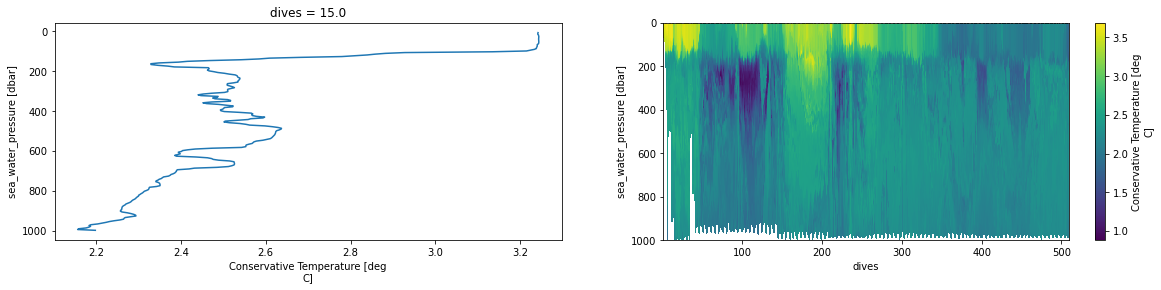

In [257]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
ds_660.CT.isel(dives=25).plot(y='ctd_pressure')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
ds_660.CT.plot(y='ctd_pressure')
plt.gca().invert_yaxis()

#### Try filtering

In [258]:
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

In [347]:
CT=ds_660.CT.T.sel(ctd_pressure=slice(250,900))

first=10
last=300
step=5
quant=int((last-first)/step)+1

temp=np.zeros((CT.dives.shape[0],CT.ctd_pressure.shape[0],quant))
filter_scales=np.zeros((quant))

for n,sig in enumerate(range(first,last+1,step)):
    sigma=sig/4/np.sqrt(12)
    temp[:,:,n]=filter.gaussian_filter1d(CT,sigma=sigma,mode='nearest')
    filter_scales[n]=sig
CT_filt=xr.DataArray(temp, dims=['dives','ctd_pressure','filt_scale'],coords={'dives':CT.dives,'ctd_pressure':CT.ctd_pressure,'filt_scale':filter_scales})

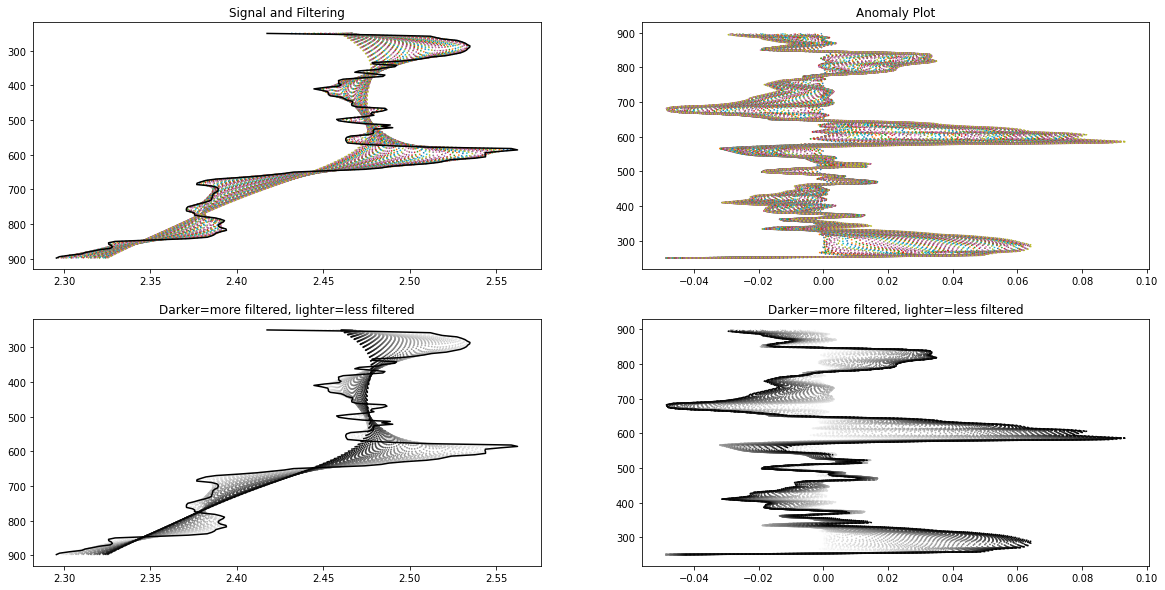

In [336]:
plt.figure(figsize=(20,10))

color=np.arange(0.01,1.01,step=1/quant)
color=np.flip(color,0)

plt.subplot(2,2,1)
prof=CT.sel(dives=25)
plt.plot(prof,prof.ctd_pressure,color='black',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")
for sig in range(first, last+1, step):
    filt=CT_filt.sel(dives=25,filt_scale=sig)
    plt.subplot(2,2,1)
    plt.plot(filt,filt.ctd_pressure,linestyle=':')
    
plt.subplot(2,2,2)
plt.title("Anomaly Plot")
for sig in range(first, last+1, step):
    filt=CT_filt.sel(dives=25,filt_scale=sig)
    anom=prof-filt
    plt.subplot(2,2,2)
    plt.plot(anom,anom.ctd_pressure,linestyle=':')

plt.subplot(2,2,3)
prof=CT.sel(dives=25)
plt.plot(prof,prof.ctd_pressure,color='black',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")
for n,sig in enumerate(range(first, last+1, step)):
    filt=CT_filt.sel(dives=25,filt_scale=sig)
    plt.subplot(2,2,3)
    plt.plot(filt,filt.ctd_pressure,linestyle=':',color=str(color[n]))

plt.subplot(2,2,4)
plt.title("Darker=more filtered, lighter=less filtered")
for n,sig in enumerate(range(first, last+1, step)):
    filt=CT_filt.sel(dives=25,filt_scale=sig)
    anom=prof-filt
    plt.subplot(2,2,4)
    plt.plot(anom,anom.ctd_pressure,linestyle=':',color=str(color[n]))

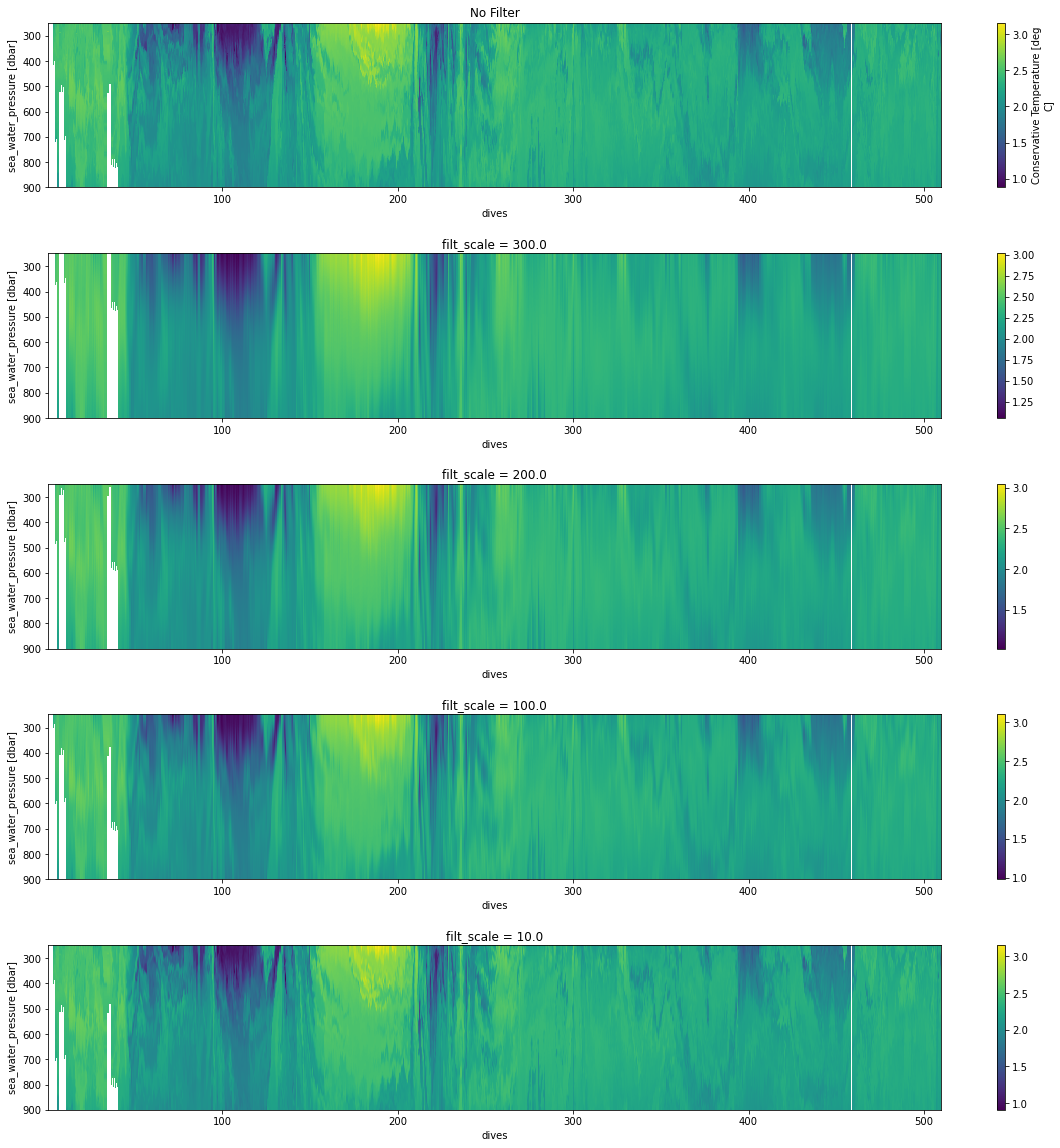

In [338]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT.plot(y='ctd_pressure')
plt.title("No Filter")
plt.gca().invert_yaxis()

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(filt_scale=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='ctd_pressure')
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

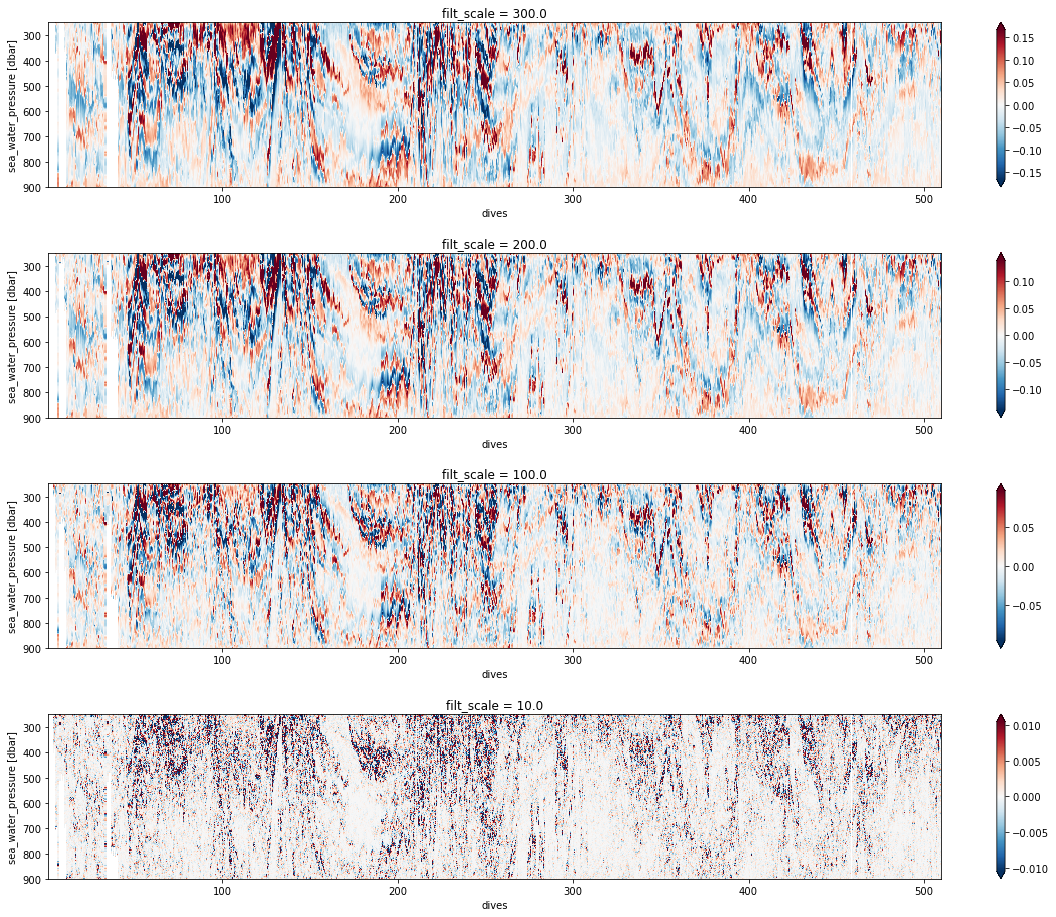

In [339]:
plt.figure(figsize=(20,20))

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(filt_scale=sig)
    anom=filt-CT
    plt.subplot(5,1,n+1)
    anom.plot(y='ctd_pressure',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [340]:
var_scale=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(filt_scale=sigma)
    var_scale[n]=(prof-CT).var()

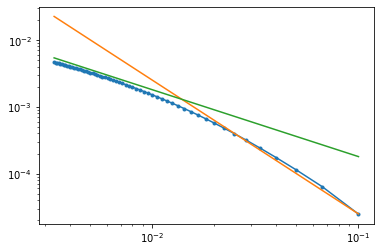

In [342]:
plt.plot(1/CT_filt.filt_scale,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.filt_scale
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

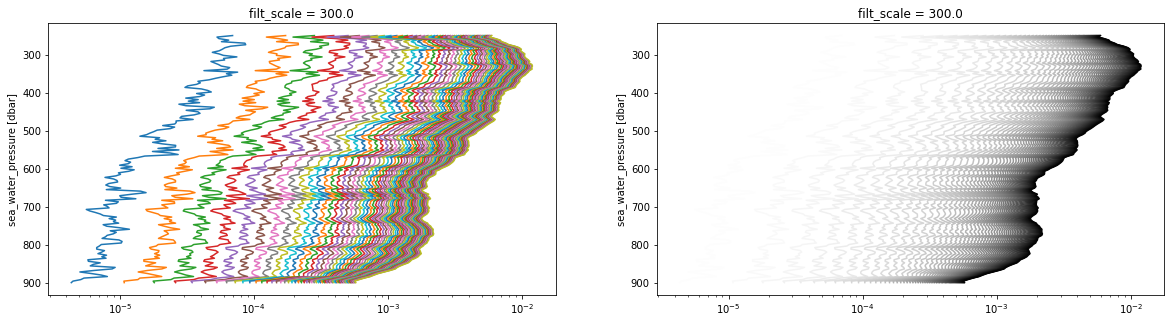

In [345]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')
for n,sig in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(filt_scale=sig)
    plt.subplot(1,2,1)
    (prof-CT).var(['dives']).plot(y='ctd_pressure',label=sig)
    
plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')
for n,sig in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(filt_scale=sig)
    plt.subplot(1,2,2)
    (prof-CT).var(['dives']).plot(y='ctd_pressure',label=sigma,color=str(color[n]))